# DECam image querying

This is currently just a test to see if image querying + fits file displaying works

Primarily from the [NOIRLab API examples](https://github.com/NOAO/nat-nb/blob/master/sia.ipynb)

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.nddata import bitmask

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd

## Downloading images from the Legacy Survey

Files are accessed through the DR10 Web Access directories mentioned on the [Legacy Survey Website](https://www.legacysurvey.org/dr10/files/).


TO DO:
- error checking if the image at the given section and brick don't exist
- figure out a method to find out which brick corresponds to a given RA/DEC

In [6]:
def obtain_image(brick, filter="g", reset_cache=True, return_bitmask=False):
    """Returns the header and data for a coadded FITS file queried from the Legacy Survey DR10 portal
    
    Files are accessed with a url pattern of `<section>/<brick>/legacysurvey-<brick>-image-<filter>.fits.fz`
    as documented on the [Legacy Survey website](https://www.legacysurvey.org/dr10/files/#image-stacks-south-coadd).
    Images can be deleted from cache after the header and data are extracted.
    
    Parameters
    ----------
    brick:  `str`
        Brick name of image: RRRr(p/m)DDd
    filter: `str`
        Photographic filter of image to request (g, r, i, z)
    reset_cache: `bool`, default `True`
        Clears the downloaded image from the cache
    return_bitmask: `bool`, default `True`
        Downloads and returns corresponding bitmask associated with image stack
        
    Returns
    -------
    header: `CompImageHeader`
        Astropy object of the FITS header data
    data: `ndarray`
        Numpy NDarray of FITS image data
    bitmask_header: `CompImageHeader`
        (Optional, `return_bitmask=True`) Astropy object of the bitmask header data
    bitmask_data: `ndarray`
        (Optional, `return_bitmask=True`) Numpy NDarray of bitmask data
    """
    
    url = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/coadd/"
    image_string = url + f"{brick[0:3]}/{brick}/legacysurvey-{brick}-image-{filter}.fits.fz"
    bitmask_string = url + f"{brick[0:3]}/{brick}/legacysurvey-{brick}-maskbits.fits.fz"
    
    
    print(f"Downloading Image: {image_string}....")

    # assumes only one image, in the first non-primary header file
    with fits.open(image_string) as hdu:
        img_header = hdu[1].header
        img_data = hdu[1].data
    
    # download corresponding MASKBITS bitmask as well
    if return_bitmask:
        print(f"Downloading Bitmask: {bitmask_string}....")
        with fits.open(bitmask_string) as hdu:
            # print(hdu.info())
            # bitmask = hdu
            bitmask_header = hdu[1].header
            bitmask_data = hdu[1].data
    
    if reset_cache:
        print("Clearing download cache...")
        data_utils.clear_download_cache(image_string)
        data_utils.clear_download_cache(bitmask_string)
    
    if return_bitmask:
        return img_header, img_data, bitmask_header, bitmask_data
    
    return img_header, img_data

header, data = obtain_image("0001m002", "g", reset_cache=False)

In [7]:
def plot_image(header, data):
    """Plots the image based on header and image data"""
    
    wcs = WCS(header)

    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection=wcs)
    lon = ax.coords['ra']
    lat = ax.coords['dec']
    ax.imshow(data, norm='linear')

    plt.tight_layout()
    
# plot_image(header, data)

## Querying the NOIRLab Astro Data Lab

to get the images we need:
- query the data lab for brick names in some RA/DEC region (ls_dr10.bricks)
- iterate through the list of brick names
- for each brick name:
  - download the image associated with it
  - extract header and image data
  - send to source extraction etc...

In [ ]:
# this function isn't actually necessary for the program but was a test to see how brick names worked
def brick_identifier(ra, dec):
    """Creates a string corresponding to the brick name of the image at a given RA/DEC
    in the format `RRRr(p/m)DDd`
    
    Example: (0.125, -0.25) -> 0001m002
    
    Parameters
    ----------
    ra: `float`
        Right ascension (degrees)
    dec: `float`
        Declination (degrees)
        
    Returns
    -------
    brickname: `str`
        Name of "brick" image
    """
    # ra RRR.rrr -> RRRr
    # dec (+/-)DD.ddd -> (p/m)DDd
    
    # whether declination is positive or negative
    sign = "p"
    if dec < 0:
        sign = "m"
    
    # remove decimal and sign
    mod_ra = round(ra*10)
    mod_dec = abs(round(dec*10))
    
    brickname = f"{mod_ra:04}{sign}{mod_dec:03}"
    print(f"Brick name for RA={ra} and DEC={dec}: {brickname}")
    
    return brickname
    
brickname = brick_identifier(0.125, -0.25)

In [ ]:
def query_bricks(ra, dec, dist):
    """Queries the Astro Data Lab for brick names and associated RA/DEC based on the given RA/DEC
    
    dist is in degrees
    """
    
    # one RA/DEC pair, then some set range around that?
    ra_max = ra + dist
    ra_min = ra - dist
    dec_max = dec + dist
    dec_min = dec - dist

    query = f"""
    SELECT brickname, ra, ra1, ra2, dec, dec1, dec2
    FROM ls_dr10.bricks_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    LIMIT 10
    """

    print(query)
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    
    return brick_info

brick_df = query_bricks(100, -25, 1.0)

In [ ]:
# get all the brick names and ra/dec of every brick below a declination of 30
# with at least 1 observation in the g filter
# this takes about 15 seconds to get ~337k brick names

query = f"""
        SELECT brickname, ra, ra1, ra2, dec, dec1, dec2
        FROM ls_dr10.bricks_s
        WHERE dec <= 30 AND nexp_g >= 1
        LIMIT 10
        """

brick_df = qc.query(sql=query, fmt="pandas")
brick_df

In [ ]:
query = f"""
        SELECT brickname
        FROM ls_dr10.bricks_s
        WHERE ra > 0 AND ra < 10 AND dec < 0 AND dec > -10
        """
        
bricks_df = qc.query(sql=query, fmt="pandas")
bricks_df

In [ ]:
query = f"""
        SELECT brickname, type, COUNT(type)
        FROM ls_dr10.tractor_s
        WHERE ra > 0 AND ra < 5 AND dec < 0 AND dec > -5
        AND mag_g <= 21
        AND type!='PSF'
        GROUP BY brickname, type
        LIMIT 100
        """

# masked_df = qc.query(sql=query, fmt="pandas")
# masked_df

In [ ]:
# AND ((maskbits & 1 != 0) OR (maskbits & 11 != 0) OR (maskbits & 12 != 0) OR (maskbits & 13 != 0))
query = f"""
        SELECT brickname
        FROM ls_dr10.tractor_s
        WHERE ra > 0 AND ra < 10 AND dec < 0 AND dec > -10
        AND (maskbits & 1 != 0)
        GROUP BY brickname
        LIMIT 1000
        """

masked_df = qc.query(sql=query, fmt="pandas")
masked_df

In [ ]:
masked_df.compare(bricks_df, align_axis=0)

In [ ]:
# get all the brick names and ra/dec of every brick below a declination of 30
# with NO observations in the g filter
# ~5s for 16k bricks

query = f"""
        SELECT brickname, ra, ra1, ra2, dec, dec1, dec2, nexp_g, nexp_i, nexp_r, nexp_z, wise_nobs_1, wise_nobs_2, wise_nobs_3, wise_nobs_4
        FROM ls_dr10.bricks_s
        WHERE dec <= 30 AND nexp_g < 1
        """

non_g_bricks = qc.query(sql=query, fmt="pandas")
non_g_bricks

Almost all of the DR10 bricks have at least one g-band observation associated with them, and those that don't are mostly along the edge of the Milky Way plane and the Magellanic Clouds. Out of the ~16k bricks that aren't accounted for in the g-band, only about 2900 only have WISE (W1, W2, W3, W4) observations that would require different calibration and image processing to handle.

In [ ]:
# bricks with r band observations
r_bricks = non_g_bricks[non_g_bricks['nexp_r']!=0]
# no r band, but i band
i_bricks = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']!=0)]
# no r or i bands, but z band
z_bricks = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']==0) & (non_g_bricks['nexp_z']!=0)]
# no r, i, or z
wise_only = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']==0) & (non_g_bricks['nexp_z']==0)]
wise_only

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(brick_df['ra'], brick_df['dec'], 'g.', label="g band")
# ax.plot(non_g_bricks['ra'], non_g_bricks['dec'], 'b.', label="non g band")
ax.plot(r_bricks['ra'], r_bricks['dec'], 'r.', label="r band")
ax.plot(i_bricks['ra'], i_bricks['dec'], 'm.', label="i band")
ax.plot(z_bricks['ra'], z_bricks['dec'], 'k.', label="z band")
ax.plot(wise_only['ra'], wise_only['dec'], 'b.', label="WISE only")


ax.set(title="LSDR10 Sky coverage by filter preference", xlabel="RA", ylabel="DEC")
ax.legend()
plt.show()

All bricks in the `brick_df` dataframe will have an associated g-band FITS image that can be downloaded from the DR10 website.

In [ ]:
arcturus = "0001m002"
arc_head, arc_data, arc_bit_head, arc_bit_data = obtain_image(arcturus, "g", reset_cache=False, return_bitmask=True)
# arc_head, arc_data = obtain_image(arcturus, "g", reset_cache=True)
# plot_image(arc_head, arc_data)


In [ ]:
def pix_to_mag(data):
    return 22.5 - 2.5*np.log10(data)

def mag_to_pix(data):
    return 10**((22.5-data)/2.5)


wcs = WCS(arc_head)
arc_data_magnitude = pix_to_mag(arc_data)
bright_data = np.zeros_like(arc_data_magnitude)

for i, row in enumerate(arc_data_magnitude):
    bright_data[i] = [pix if pix <= 21 else 0 for pix in row]

# bright_data = bright_data & arc_data_magnitude <= 21

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
lon.set_major_formatter('d.ddd')
lat.set_major_formatter('d.ddd')
# plt.imshow(arc_data_magnitude)
plt.imshow(bright_data, cmap='gray_r')
plt.colorbar(ax=ax)
ax.set(title="All saturation in g/r/z", xlabel="RA", ylabel="DEC")

plt.tight_layout()

plot_image(arc_head, arc_data)

In [ ]:
def find_bad_pixels(bitmask_array, flags):
    """Returns an array of the same shape of the bitmask with 1's where 'bad pixels' are located
    
    Flags should be integers from 0 to 15. Relevant flags for LSDR10 from [MASKBITS](https://www.legacysurvey.org/dr10/bitmasks/):
    0  = 'NPRIMARY'           / maskbits bit 0 (0x1): not primary brick area   
    1  = 'BRIGHT  '           / maskbits bit 1 (0x2): bright star nearby       
    2  = 'SATUR_G '           / maskbits bit 2 (0x4): g band saturated         
    3  = 'SATUR_R '           / maskbits bit 3 (0x8): r band saturated         
    4  = 'SATUR_Z '           / maskbits bit 4 (0x10): z band saturated        
    5  = 'ALLMASK_G'          / maskbits bit 5 (0x20): any ALLMASK_G bit set   
    6  = 'ALLMASK_R'          / maskbits bit 6 (0x40): any ALLMASK_R bit set   
    7  = 'ALLMASK_Z'          / maskbits bit 7 (0x80): any ALLMASK_Z bit set   
    8  = 'WISEM1  '           / maskbits bit 8 (0x100): WISE W1 (all masks)    
    9  = 'WISEM2  '           / maskbits bit 9 (0x200): WISE W2 (all masks)    
    10 = 'BAILOUT '           / maskbits bit 10 (0x400): Bailed out processing 
    11 = 'MEDIUM  '           / maskbits bit 11 (0x800): medium-bright star    
    12 = 'GALAXY  '           / maskbits bit 12 (0x1000): SGA large galaxy     
    13 = 'CLUSTER '           / maskbits bit 13 (0x2000): Globular cluster     
    14 = 'SATUR_I '           / maskbits bit 14 (0x4000): i band saturated     
    15 = 'ALLMASK_I'          / maskbits bit 15 (0x8000): any ALLMASK_I bit set
    """
    
    print(f"Flags to mask: {flags}")
    ok_flags = 2**np.arange(0,16)
    ok_flags = np.delete(ok_flags, flags)
    
    bad_pix = bitmask.bitfield_to_boolean_mask(bitmask_array, ignore_flags=ok_flags)
    return bad_pix

# masks pixels with saturation in g, r, z bands
bad_pix_saturation = find_bad_pixels(arc_bit_data, [2,3,4])

# masks pixels with any ALL_MASK_X bit in g, r, z bands
bad_pix_allmasks = find_bad_pixels(arc_bit_data, [5, 6, 7])

# masks pixels with g band saturation or ALL_MASK bits
bad_pix_gband = find_bad_pixels(arc_bit_data, np.arange(0,16))

In [ ]:
wcs = WCS(arc_head)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(131, projection=wcs)
ax2 = plt.subplot(132, projection=wcs)
ax3 = plt.subplot(133, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']

ax.imshow(bad_pix_saturation)
ax.set(title="All saturation in g/r/z", xlabel="RA", ylabel="DEC")
ax2.imshow(bad_pix_allmasks)
ax2.set(title="Bright star", xlabel="RA", ylabel="DEC")
ax3.imshow(bad_pix_gband)
ax3.set(title="Medium star", xlabel="RA", ylabel="DEC")

plt.tight_layout()

## Dealing with All of the bricks

In [ ]:
import astropy.units as u
total_bricks = len(brick_df) + len(non_g_bricks)

optimistic_estimate = total_bricks * u.s
pessimistic_estimate = total_bricks * 5 * u.s

print(f"For {total_bricks} bricks:")
print(f"Optimistic (1 sec per brick): {optimistic_estimate.to(u.hour):.2f} ({optimistic_estimate.to(u.day):.2f})")
print(f"Pessimistic (5 sec per brick): {pessimistic_estimate.to(u.hour):.2f} ({pessimistic_estimate.to(u.day):.2f})")

In [ ]:
def iterate_bricks(brick_df):
    """Iterate through a dataframe of brick names and generate the images from them
    """
    
    image_array = []
    
    for brick in brick_df['brickname']:
        print(brick)
        head, data = obtain_image(brick, "g")
        image_array.append((head, data))  
    
    return image_array
        
image_array = iterate_bricks(brick_df[0:6])

In [ ]:
for image in image_array:
    plot_image(image[0], image[1])

## Using the mask summary

In [2]:
# WARNING this takes a long time (~4 min)

def generate_masked_stars(dec=30):
    """Generates a numpy file object of the masked stars
    
    DO NOT run this function unless absolutely necessary!!!!
    It takes ~4 minutes on its own excluding the amount of time needed to download
    the mask fits file.
    
    Parameters
    ----------
    dec: `float`
        Maximum declination to cut off the catalog at (default = 30)
    """
    
    mask_string = "/mnt/c/Users/creat/Downloads/gaia-mask-dr10.fits.gz"
    # mask_string = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/masking/gaia-mask-dr10.fits.gz"
    print("Loading file...")
    hdu = fits.open(mask_string, memmap=True)
    
    # hdu.info()
    print("File loaded. Assigning header and data...")
    mask_header = hdu[1].header
    mask_data = hdu[1].data

    # check if sources in desi and isbright / is medium
    print("Checking for bright/medium stars in DESI footprint...")
    mask_data_cut = mask_data[(mask_data['isbright'] | mask_data['ismedium'])]

    # drop unneeded columns first
    print("Dropping unneeded columns...(Retaining ra, dec, radius)")
    drop_fields = mask_data_cut.names
    allowed_fields = ['ra', 'dec', 'radius']
    drop_fields = [field for field in drop_fields if field not in allowed_fields]
    mask_data_cut = np.lib.recfunctions.rec_drop_fields(mask_data_cut, drop_fields)
    
    # Cut out all stars at declinations above DEC
    print(f"Removing stars above DEC = {dec}")
    mask_data_cut = mask_data_cut[mask_data_cut['dec'] < dec]

    # close everything
    print("Data cleaned!")
    hdu.close()
    del hdu
    
    return mask_data_cut

mask_data_cut = generate_masked_stars()

Loading file...
File loaded. Assigning header and data...
Checking for bright/medium stars in DESI footprint...
Dropping unneeded columns...(Retaining ra, dec, radius)
Removing stars above DEC = 30
Data cleaned!


In [3]:
# only consider stuff below a declination of 30

def generate_boxes(ra_interval, dec_interval):
    
    
    ra_ranges = np.arange(0, 360, ra_interval)
    dec_ranges = np.arange(-90, 30, dec_interval)

    print(ra_ranges)
    print(dec_ranges)
    
    mask_box = []
    
    for ra in ra_ranges:
        ra_bounds = (mask_data_cut['ra'] > ra) & (mask_data_cut['ra'] < ra+ra_interval)
        
        for dec in dec_ranges:
            dec_bounds = (mask_data_cut['dec'] > dec) & (mask_data_cut['dec'] < dec+dec_interval)
            
            print(f"RA: {ra}, DEC: {dec}")
            mask_box.append(mask_data_cut[ra_bounds & dec_bounds])
        
    return mask_box

mask_box = generate_boxes(120, 30)


[  0 120 240]
[-90 -60 -30   0]
RA: 0, DEC: -90
RA: 0, DEC: -60
RA: 0, DEC: -30
RA: 0, DEC: 0
RA: 120, DEC: -90
RA: 120, DEC: -60
RA: 120, DEC: -30
RA: 120, DEC: 0
RA: 240, DEC: -90
RA: 240, DEC: -60
RA: 240, DEC: -30
RA: 240, DEC: 0


In [ ]:
for i, box in enumerate(mask_box):
    np.savez_compressed(f'mask_data_box_{i}', box)

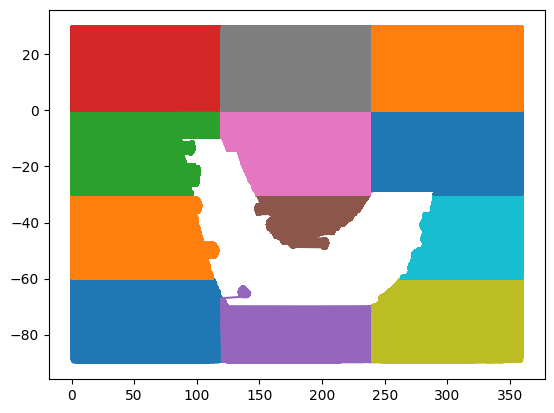

In [4]:
fig, ax = plt.subplots()
# ax.plot(mask_data_cut['ra'], mask_data_cut['dec'])
for box in mask_box:
    ax.plot(box['ra'], box['dec'])
# ax.vlines(ra_ranges, ymin=-90, ymax=30, color='r')
# ax.hlines(dec_ranges, xmin=0, xmax=360, color='r')
plt.show()

In [13]:
np.savez_compressed('mask_data_full', mask_data_cut)
# print(mask_data_cut.nbytes)

In [ ]:
ra_1 = 0.255965935903178
dec_1 = -0.380962387829748
ra_2 = 359.994034064097
dec_2 = -0.119036306008142

ra_range = (mask_data_cut['ra'] < ra_1) | (mask_data_cut['ra'] > ra_2)
dec_range = (mask_data_cut['dec'] > dec_1) & (mask_data_cut['dec'] < dec_2)
# box_range = (mask_data_cut['ra'] < ra_1) & (mask_data_cut['ra'] > ra_2) & (mask_data_cut['dec'] > dec_1) & (mask_data_cut['dec'] < dec_2)

mask_data_box = mask_data_cut[dec_range & ra_range]
mask_data_box
# print(np.min(mask_data_box['ra']))

In [44]:
mask_data_box.dtype.names
np.savetxt("mask_data.txt", mask_data_box, header=' '.join(mask_data_box.dtype.names))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(mask_data_box['ra'], mask_data_box['dec'], s=mask_data_box['radius']*10000)
ax.set(xlim=(0, ra_1), ylim=(dec_1, dec_2))
plt.show()